## Generating the dataset
Generating the dataset for runge function from -1 to 1

In [51]:
import numpy as np

np.random.seed(42)

n = 50

x = np.linspace(-1,1,n)
y = 1/(1+25*x**2) 
y = y.reshape(n,1) 
y_noise = y + np.random.normal(0,0.1)


## Part a : OLS for Runge


Write your own code (using for example the pseudoinverse function pinv from Numpy ) and
perform a standard ordinary least square regression analysis using polynomials in x up to
order 15 or higher. Explore the dependence on the number of data points and the polynomial
degree.

In [52]:
def polynomial_features(x, p, intercept=False):
    n = len(x)
    k = 0
    if intercept:
        X = np.zeros((n, p + 1))
        X[:, 0] = 1
        k += 1
    else:
        X = np.zeros((n, p))

    for i in range(1, p +1):
        X[:, i + k-1] = x**i 
    return X


#### Derivation of the OLS analytical solution
Using this relationship 
$$
\frac{\partial \left(\boldsymbol{x}-\boldsymbol{A}\boldsymbol{s}\right)^T\left(\boldsymbol{x}-\boldsymbol{A}\boldsymbol{s}\right)}{\partial \boldsymbol{s}} = -2\left(\boldsymbol{x}-\boldsymbol{A}\boldsymbol{s}\right)^T\boldsymbol{A},
$$

and noting that the minimum point is where this derivate is equal to 0 gives

$$
\begin{aligned}
0 &= -2 (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T \boldsymbol{X} \\
0 &= y^T X - \theta^T X^T X \\
\theta^T &= y^T X (X^T X) ^{-1}\\
\theta &= (X^T X)^{-1} X^T y
\end{aligned}
$$

### Code
OLS analytical solution using pseudo pinv

In [53]:
# Ordinary Least Squares Analytical solution
def OLS_parameters(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def MSE(y, y_pred):
    return np.mean((y - y_pred)**2)

def R2(y, y_pred):
    return 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))

Analysis with polynomials in x up to 15 degrees where we take a train-test split to see how the trained model performs on unseen data. Where we do the scaling since x^1 and x^15 are quite far between, so the floating term operations on the computer becomes more ill defined or close to zero. So even though the solution is analytical we will necessarily have some approximation since we are using a computer and the numbers usually wont have few floating points. We also subtract the mean from the y values 

Plot saved as Combined_Analysis_3_Plots.png


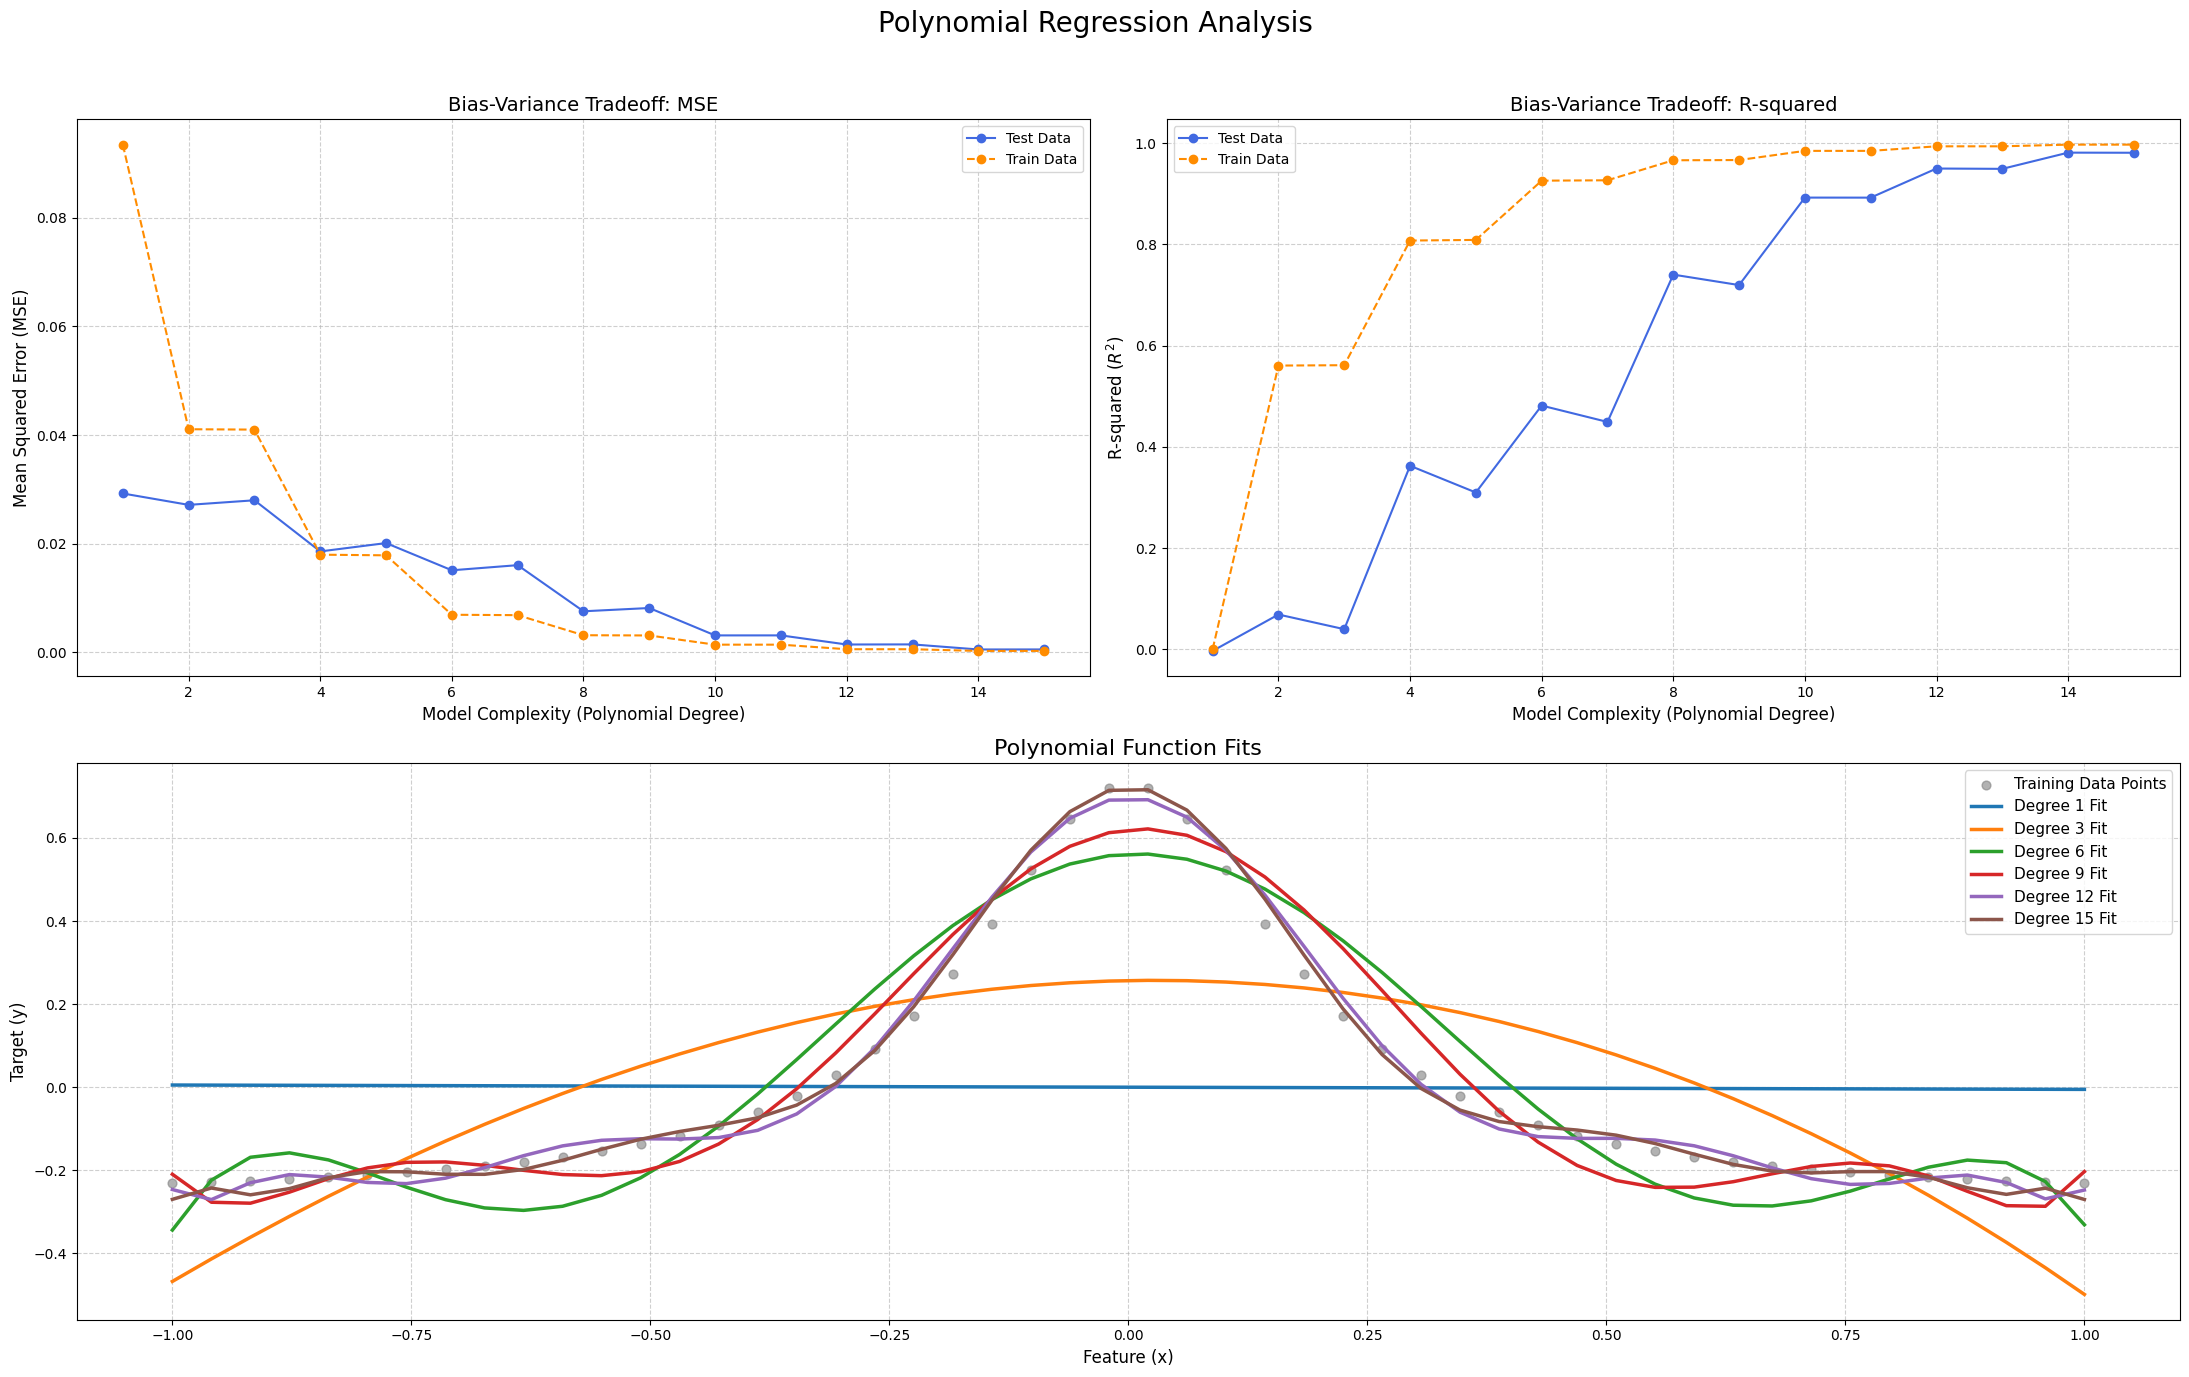

Plot saved as OLS_BiasVariance_SideBySide.png


<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plot_predict = {"mse" :[],
                "r2" : []}
plot_train = {"mse":[],
              "r2": []}
beta_norms = []
degrees = np.arange(1, 16)

for degree in degrees:
    X = polynomial_features(x, degree)
    y = y - y.mean()  # Centering the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)
    
    # Scaling the data for numerical stability
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    beta = OLS_parameters(X_train, y_train)
    beta_norms.append(beta)

    y_pred = X_test @ beta
    y_train_pred = X_train @ beta
    mse_predict = MSE(y_test, y_pred)
    mse_train = MSE(y_train, y_train_pred)
    r2_predict = R2(y_test, y_pred)
    r2_train = R2(y_train, y_train_pred)
    
    plot_predict["mse"].append(mse_predict)
    plot_predict["r2"].append(r2_predict)
    plot_train["mse"].append(mse_train)
    plot_train["r2"].append(r2_train)

fig = plt.figure(figsize=(22, 14))
gs = gridspec.GridSpec(2, 2)
fig.suptitle('Polynomial Regression Analysis', fontsize=20)

ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, :]) 

ax1.plot(degrees, plot_predict["mse"], label="Test Data", marker='o', color='royalblue')
ax1.plot(degrees, plot_train["mse"], label="Train Data", marker='o', linestyle='--', color='darkorange')
ax1.set_xlabel("Model Complexity (Polynomial Degree)", fontsize=12)
ax1.set_ylabel("Mean Squared Error (MSE)", fontsize=12)
ax1.set_title("Bias-Variance Tradeoff: MSE", fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
# Set a y-limit to keep the plot readable, as MSE can explode for high degrees


# --- Plot 2: R-squared (on the second axis, ax2) ---
ax2.plot(degrees, plot_predict["r2"], label="Test Data", marker='o', color='royalblue')
ax2.plot(degrees, plot_train["r2"], label="Train Data", marker='o', linestyle='--', color='darkorange')
ax2.set_xlabel("Model Complexity (Polynomial Degree)", fontsize=12)
ax2.set_ylabel("R-squared ($R^2$)", fontsize=12)
ax2.set_title("Bias-Variance Tradeoff: R-squared", fontsize=14)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
# R2 is bounded by 1, negative values indicate a very poor fit


ax3.scatter(x, y, label='Training Data Points', color='gray', alpha=0.6, s=40)


plotted_degrees = [1, 3, 6, 9, 12, 15]

for degree in plotted_degrees:
    X_full = polynomial_features(x, degree)
    scaler = StandardScaler()
    X_full_scaled = scaler.fit_transform(X_full)
    y_pred = X_full_scaled @ beta_norms[degree - 1]
    
    ax3.plot(x, y_pred, label=f'Degree {degree} Fit', linewidth=2.5)

ax3.set_xlabel("Feature (x)", fontsize=12)
ax3.set_ylabel("Target (y)", fontsize=12)
ax3.set_title("Polynomial Function Fits", fontsize=16)
ax3.legend(fontsize=11)
ax3.grid(True, linestyle='--', alpha=0.6)


# --- Save and show the final combined plot ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Combined_Analysis_3_Plots.png")
print("Plot saved as Combined_Analysis_3_Plots.png")
plt.show()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Save the figure to a file and display it
plt.savefig("OLS_BiasVariance_SideBySide.png")
print("Plot saved as OLS_BiasVariance_SideBySide.png")
plt.show()